<h1><center>IMT2118 - Ciencia de Datos Geoespaciales </center></h1>
<h2><center>E2:  Islas de calor urbanas y violencia contra la mujer en Nueva York  </center></h2>

Cuando hablamos de violencia de género, nos referimos a conductas violentas cuya motivación última es la pertenencia a un género. Según la subcomisión de estadísticas de género (SEG), durante el año 2020 hubo 44 femicidos consumados y 163 intentos frustrados $^1$. Es por esto que la violencia de género es un problema relevante, el cual requiere de la formulación de políticas públicas para ser abordado correctamente. 

Para los objetivos de este trabajo, se abordará exclusivamente la violencia ejercida desde hombres a mujeres, y limitada al siguiente subconjunto de crímenes obtenidos de las columnas de nuestro dataset:violación, acoso, secuestro, crímenes sexuales y homicidio.



**Referencias:**
1. Subcomisión de Estadísticas de Género (SEG) (n.d.). VIolencia de género. EstadíSticas de géNero. Retrieved July 2, 2023, from https://www.estadisticasdegenero.cl/indicadores/violencia-de-genero/

### 1. Importaciones y lecturas

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import ee
import geemap
from shapely.geometry import box
import numpy as np
import seaborn as sns

In [2]:
# ee.Authenticate()
ee.Initialize()

In [3]:
big_crimes = gpd.read_file('NYPD_violence_against_women.gpkg')
big_crimes.to_crs('EPSG:4326', inplace=True)

In [4]:
manz = gpd.read_file('squares/nyct2020.shp')
manz.to_crs('EPSG:4326', inplace=True)
manz.head(1)

CTLabel BoroCode   BoroName  CT2020 BoroCT2020 CDEligibil   
0       1        1  Manhattan  000100    1000100       None  \

                                             NTAName NTA2020 CDTA2020   
0  The Battery-Governors Island-Ellis Island-Libe...  MN0191     MN01  \

                                            CDTANAME        GEOID  PUMA   
0  MN01 Financial District-Tribeca (CD 1 Equivalent)  36061000100  4121  \

     Shape_Leng    Shape_Area   
0  10833.043929  1.843005e+06  \

                                            geometry  
0  MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...

<Axes: >

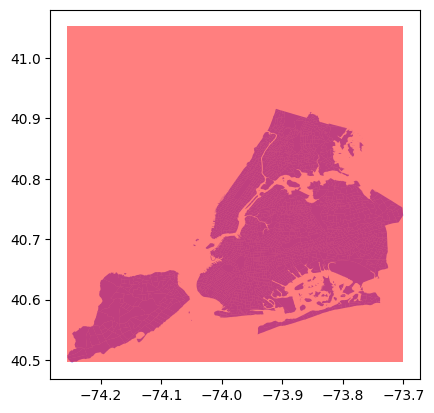

In [52]:
unif = manz.unary_union
bounding_box = unif.bounds
minx, miny, maxx, maxy = bounding_box
width = max(maxx - minx, maxy - miny)
expanded_bbox = box(minx, miny, minx + width, miny + width)
ny_box = gpd.GeoDataFrame(geometry=[expanded_bbox])
ax = manz.plot(color='blue', alpha=0.5)
ny_box.plot(ax=ax, color='red', alpha=0.5)

In [53]:
poly = ny_box.geometry.iloc[0]
xy = list(poly.exterior.coords)
aoi = ee.Geometry.Polygon([xy[0], xy[1], xy[2], xy[3]])
x = aoi.centroid().getInfo()['coordinates'][0]
y = aoi.centroid().getInfo()['coordinates'][1]
aoi2 = ee.Geometry.Point([x-.1, y-.1])

### 2. Visualización de HeatMaps

In [54]:
def cloudMask(image):
    qa = image.select('QA_PIXEL')
    mask = qa.bitwiseAnd(1 << 3).Or(qa.bitwiseAnd(1 << 4))
    return image.updateMask(mask.Not())


def applyScaleFactors(image):
    thermalband = image.select('ST_B10').multiply(0.00341802).add(149.0).subtract(273.15)
    return image.addBands(srcImg=thermalband, overwrite=True)

In [55]:
# "LANDSAT/LE07/C01/T1"
# https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC09_C02_T1_L2

collection = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2").filterBounds(aoi).filterDate('2022-05-30', '2022-07-10').map(cloudMask)
filtered_l8 = collection.filter(ee.Filter.lt('CLOUD_COVER', 25))
landsatST = filtered_l8.map(applyScaleFactors)
mean_landsatST = landsatST.mean()
clip_mean_ST = mean_landsatST.clip(aoi)

images=collection.aggregate_array('system:id').getInfo()
print(len(images))

7


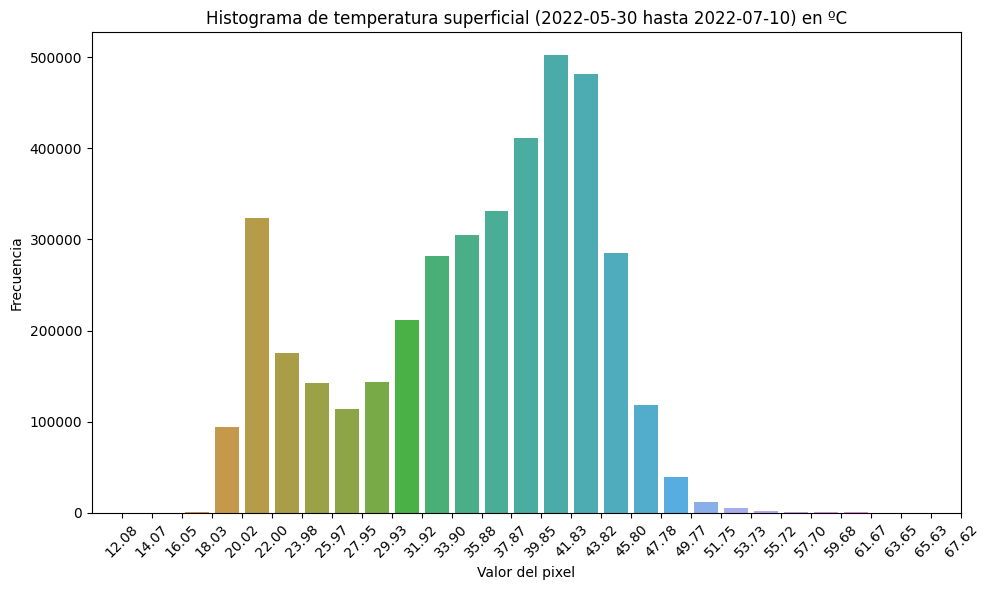

In [56]:
values_ST = clip_mean_ST.select('ST_B10')
histogram_ST = values_ST.reduceRegion(
    reducer=ee.Reducer.histogram(30),
    geometry=aoi,
    scale=30
)

values_ST = clip_mean_ST.select('ST_B10')
histogram_info = histogram_ST.get('ST_B10').getInfo()
histogram_values = histogram_info['histogram']
bucket_means = histogram_info['bucketMeans']

num_bins = len(histogram_values)
min_value = bucket_means[0] - (bucket_means[1] - bucket_means[0]) / 2
max_value = bucket_means[-1] + (bucket_means[-1] - bucket_means[-2]) / 2
bin_edges = np.linspace(min_value, max_value, num_bins + 1)

histogram_df = pd.DataFrame({'bin_edges': bin_edges[:-1], 'histogram_values': histogram_values})

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=histogram_df, x='bin_edges', y='histogram_values')
plt.xlabel('Valor del pixel')
plt.ylabel('Frecuencia')
plt.title('Histograma de temperatura superficial (2022-05-30 hasta 2022-07-10) en ºC')

tick_positions = np.arange(len(bin_edges[:-1])) + 0.5
tick_labels = [f'{val:.2f}' for val in bin_edges[:-1]]
plt.xticks(tick_positions, tick_labels)
plt.xticks(rotation=45)
plt.tight_layout()

In [57]:
Map = geemap.Map()
heat_params = {'min': 20,
    'max': 50,
    'bands': 'ST_B10',
    'palette': ['blue', 'purple', 'yellow', 'orange','red']}
Map.addLayer(clip_mean_ST, heat_params, 'ST')
Map.centerObject(aoi2, 10)
Map

Map(center=[40.673871012612906, -74.07780021318202], controls=(WidgetControl(options=['position', 'transparent…

In [58]:
heat_islands = clip_mean_ST.gt(48).selfMask()
hi_params = {
    'bands': 'ST_B10',
    'palette': 'black'}
Map.addLayer(heat_islands, hi_params, 'Heat Islands')

A continuación, veremos añadiremos al plot distintos rangos de fechas.

In [59]:
layer_list = []
for i in range(1, 11):
    col = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2").filterBounds(aoi).filterDate(f'2022-{i}-30', f'2022-{i+2}-10').map(cloudMask)
    filtered= collection.filter(ee.Filter.lt('CLOUD_COVER', 25))
    landST = filtered_l8.map(applyScaleFactors)
    mean_ST = landsatST.mean()
    clip_mean_ST = mean_landsatST.clip(aoi)
    layer_list.append(clip_mean_ST)

In [60]:
layer_list

In [61]:
Map2 = geemap.Map()
for i,layer in enumerate(layer_list):
    layer
    Map2.addLayer(layer, heat_params, f'H.I 0{i+1}-30 to {i+3}-10')

Map2.centerObject(aoi2, 10)
Map2

Map(center=[40.673871012612906, -74.07780021318202], controls=(WidgetControl(options=['position', 'transparent…

### 3. Visualizar información de crimenes

<Axes: >

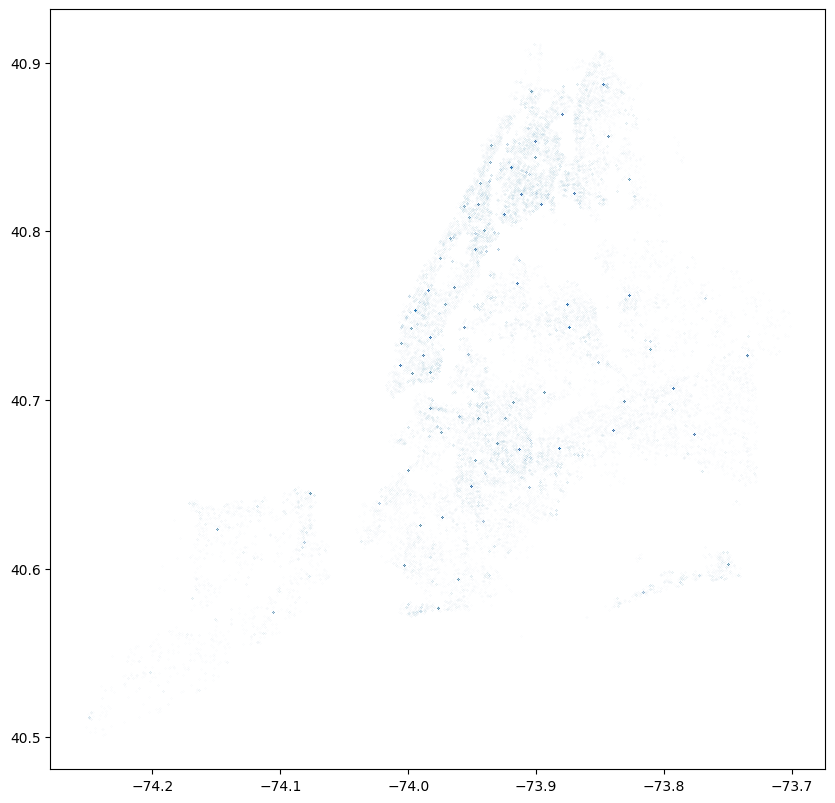

In [15]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
big_crimes.plot(ax=ax, alpha=0.1, markersize=0.01)

### 4. Normalizar información de crímenes por cantidad de mujeres para el periodo relevante (2022)

In [5]:
every_manz_crimes = list()
for i in range(len(manz)):
    n_crimes = big_crimes.within(manz.iloc[i].geometry)
    every_manz_crimes.append(sum(n_crimes))
manz["n_crimes"] = every_manz_crimes

Ahora leemos el censo 2020 de NY, y nos quedamos con las manzanas en las cuales tenemos 

In [6]:
census_tracts = gpd.read_file('census/nyc_census_tracts.csv')

In [7]:
manz_filtered = manz[manz['GEOID'].isin(census_tracts['CensusTract'].unique())]
census_filtered = census_tracts[census_tracts['CensusTract'].isin(manz['GEOID'].unique())]

In [8]:
census_filtered = census_filtered[['CensusTract', 'TotalPop', 'Women']]

In [9]:
squares = manz_filtered.merge(census_filtered, left_on='GEOID', right_on='CensusTract')
squares = squares.drop('CensusTract', axis=1)

In [43]:
def proportion(TotalPop, subgroup):
    if float(TotalPop) == 0:
        return 0
    else:
        return float(subgroup)/float(TotalPop)

In [44]:
cant_mujeres = sum(squares['Women'].astype('float64'))
squares['women_prop'] = squares.apply(lambda x: proportion(x.TotalPop, x.Women), axis=1)
squares['area_km2'] = squares.to_crs('EPSG:2263').geometry.area * 0.000000092903
squares['crimes_prop'] = squares.apply(lambda x: proportion(x.area_km2, x.n_crimes), axis=1)
squares.sample(3)

CTLabel BoroCode  BoroName  CT2020 BoroCT2020 CDEligibil   
981      466        4    Queens  046600    4046600       None  \
1584     534        3  Brooklyn  053400    3053400       None   
976     1621        4    Queens  162100    4162100       None   

                         NTAName NTA2020 CDTA2020   
981   Jamaica Estates-Holliswood  QN0804     QN08  \
1584                     Midwood  BK1403     BK14   
976                    Bellerose  QN1302     QN13   

                                               CDTANAME  ...    Shape_Leng   
981   QN08 Fresh Meadows-Hillcrest-Briarwood (CD 8 A...  ...   7923.924902  \
1584        BK14 Flatbush-Midwood (CD 14 Approximation)  ...   5639.951384   
976   QN13 Queens Village-Bellerose-Rosedale (CD 13 ...  ...  13319.987789   

        Shape_Area                                           geometry   
981   2.591346e+06  POLYGON ((-73.78059 40.71343, -73.78178 40.713...  \
1584  1.866106e+06  POLYGON ((-73.96094 40.62279, -73.96049 40.620...   
976   7.751012e+06  POLYGON ((-73.72766 40.73111, -73.72729 40.731...   

      n_crimes TotalPop  Women women_prop crimes_prop      area  area_km2  
981          7     3521   2030   0.576541   29.076859  0.240741  0.240741  
1584         6     4227   2120   0.501538   34.608697  0.173367  0.173367  
976         17     7167   3603   0.502721   23.608081  0.720092  0.720092  

[3 rows x 22 columns]

<Axes: >

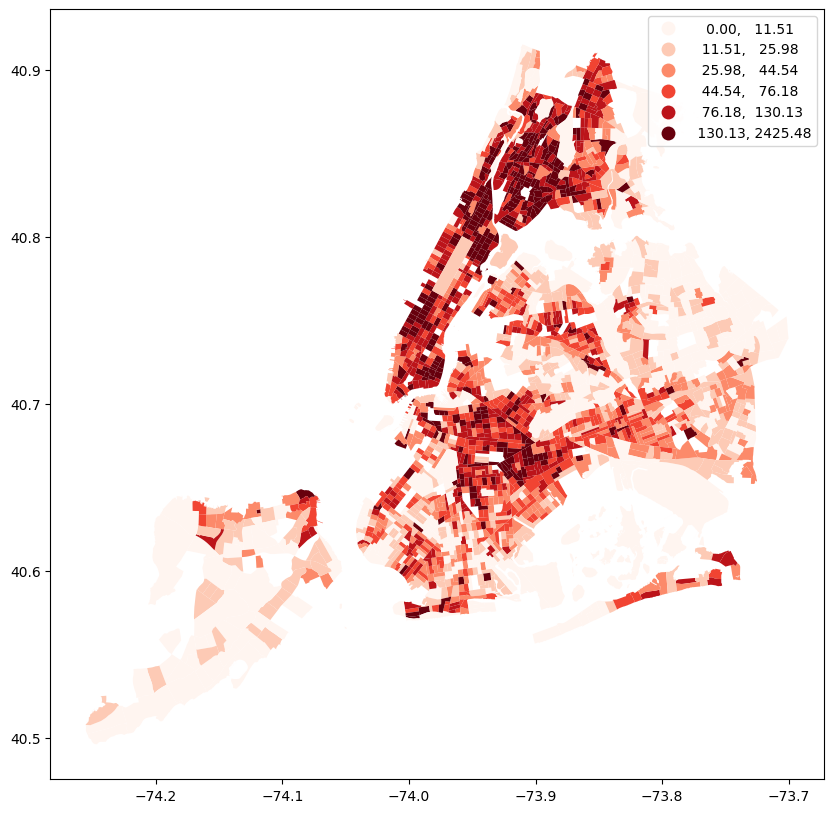

In [50]:
squares.plot(column='crimes_prop', scheme='quantiles', k=6, cmap='Reds', figsize=(10,10), legend=True)

## Discretización de raster de temperatura

In [107]:
list_temp = list()
for sq in squares.iterrows():
    mean_temp = 0
    img_sq = clip_mean_ST.select('ST_B10').clip(sq[1][14])
    n_pix = len(np.array(img_sq).flatten())
    for pix in np.array(img_sq).flatten():
        print(pix)
        # mean_temp += pix
    list_temp.append(mean_temp/n_pix)

squares["mean_temperature"] = list_temp

EEException: Can't encode object: MULTIPOLYGON (((-74.04387761639944 40.69018767587401, -74.04350596078567 40.6896873596363, -74.04273533892976 40.69005019091781, -74.04278433380006 40.690120976691354, -74.04270428426766 40.6901552046445, -74.04255372037339 40.68996275979237, -74.0426392937119 40.68992817641353, -74.04269380819214 40.689997259609974, -74.04346752310298 40.68963699060623, -74.04351637245855 40.689191033742546, -74.04364078627445 40.68876656007293, -74.04397458556184 40.68858240705612, -74.04438521777247 40.68851617790029, -74.04478399106388 40.688595660115816, -74.04627539003668 40.689327425896934, -74.04680284898575 40.689953256266215, -74.0474765152837 40.689611369998204, -74.047729627631 40.689915318968794, -74.04758571924822 40.68998250732891, -74.0474312612351 40.68980389047109, -74.04689205500591 40.69005909832281, -74.04720029366251 40.69042481562394, -74.04711050698607 40.690470412850274, -74.04711582042361 40.69065580611837, -74.04718321412064 40.690747355049275, -74.04719492513735 40.69076326384838, -74.04721324567835 40.69079048732637, -74.04722568425278 40.69081957243567, -74.04723192827254 40.69084978826996, -74.04723182081725 40.690880375506964, -74.04722536457862 40.69091056549009, -74.04721272179357 40.690939599544606, -74.04719421016807 40.690966748043444, -74.0471702948939 40.690991328742676, -74.04714091053252 40.691010516344676, -74.04710814053631 40.69102620847252, -74.04707269656511 40.69103806434227, -74.0470353483505 40.69104582648133, -74.04699690697936 40.69104932632006, -74.04617167065449 40.69109798148653, -74.04614707208665 40.691122646033364, -74.04609551065151 40.69112006354922, -74.0460444245555 40.69111415266101, -74.04599418395566 40.6911049561975, -74.04592592767887 40.691082603798115, -74.04586027427413 40.691056116583574, -74.04460616482923 40.69057348495099, -74.04387761639944 40.69018767587401)), ((-74.03995040788483 40.70089063014033, -74.03945262913307 40.700533159823905, -74.03938278118848 40.70057769456149, -74.03771124796636 40.69934404034792, -74.03809786214774 40.6990395052444, -74.03822954445391 40.6983685916979, -74.03900043878028 40.69836989039119, -74.0393403767015 40.69811551483617, -74.03993272132986 40.69854442279385, -74.04025555083275 40.69880482330749, -74.04124261832222 40.69953674143506, -74.04174768868015 40.69914786356684, -74.03991248872623 40.697702040398596, -74.04166051914841 40.696452971639935, -74.04367371230778 40.69802040433027, -74.04363686211197 40.69804823269846, -74.04365651062231 40.69806409108808, -74.04270395810723 40.69880060058688, -74.04296505227515 40.69899936182236, -74.0410986123707 40.70049294338983, -74.04080080646241 40.7002685499267, -74.04031250973529 40.70062574919241, -74.04028808803947 40.70064361346732, -74.03995040788483 40.70089063014033)))

In [100]:
for sq in squares.iterrows():
    print(sq[1][14])

MULTIPOLYGON (((-74.04387761639944 40.69018767587401, -74.04350596078567 40.6896873596363, -74.04273533892976 40.69005019091781, -74.04278433380006 40.690120976691354, -74.04270428426766 40.6901552046445, -74.04255372037339 40.68996275979237, -74.0426392937119 40.68992817641353, -74.04269380819214 40.689997259609974, -74.04346752310298 40.68963699060623, -74.04351637245855 40.689191033742546, -74.04364078627445 40.68876656007293, -74.04397458556184 40.68858240705612, -74.04438521777247 40.68851617790029, -74.04478399106388 40.688595660115816, -74.04627539003668 40.689327425896934, -74.04680284898575 40.689953256266215, -74.0474765152837 40.689611369998204, -74.047729627631 40.689915318968794, -74.04758571924822 40.68998250732891, -74.0474312612351 40.68980389047109, -74.04689205500591 40.69005909832281, -74.04720029366251 40.69042481562394, -74.04711050698607 40.690470412850274, -74.04711582042361 40.69065580611837, -74.04718321412064 40.690747355049275, -74.04719492513735 40.690763263